Data shape: (500, 6)
   TransactionID  Amount  Age TransactionType  LocationMatch  IsFraud
0              1     870   40            Chip              0        1
1              2    3782   33           Swipe              0        1
2              3    3102   56           Swipe              1        0
3              4     476   62           Swipe              1        0
4              5    4436   59     Contactless              1        0

Value counts for target (IsFraud):
IsFraud
0    306
1    194
Name: count, dtype: int64

Feature columns: ['Amount', 'Age', 'LocationMatch', 'TransactionType_Contactless', 'TransactionType_Online', 'TransactionType_Swipe']

Train class distribution:
 IsFraud
0    0.6125
1    0.3875
Name: proportion, dtype: float64

Training Logistic Regression...
Training Random Forest...

=== Evaluation: Logistic Regression ===
Accuracy: 0.85
Precision: 0.75
Recall: 0.9231
ROC AUC: 0.9529

Confusion Matrix:
[[49 12]
 [ 3 36]]

Classification Report:
              preci

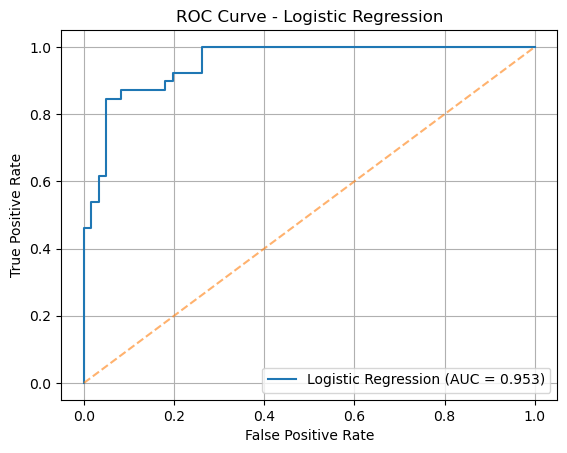


=== Evaluation: Random Forest ===
Accuracy: 0.85
Precision: 0.7727
Recall: 0.8718
ROC AUC: 0.9243

Confusion Matrix:
[[51 10]
 [ 5 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        61
           1       0.77      0.87      0.82        39

    accuracy                           0.85       100
   macro avg       0.84      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



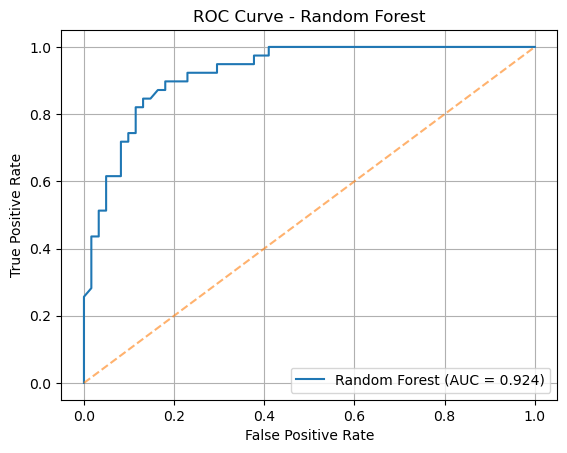


Logistic AUC: 0.9529  |  RandomForest AUC: 0.9243
Best model chosen: Logistic Regression
Saved model to: best_fraud_model.joblib


In [1]:
"""
Credit Card Fraud Detection - Beginner-Friendly Script
- Assumes a CSV with columns: TransactionID, Amount, Age, TransactionType, LocationMatch, IsFraud
- Produces: training, evaluation, model file saved with joblib
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import joblib
import os

# ---------- CONFIG ----------
CSV_PATH = "C:/Users/My Pc/Desktop/Sayali/new_transactions_folder/credit_card_fraud_500.csv"   # change path if needed
RANDOM_STATE = 42
TEST_SIZE = 0.2
SAVE_MODEL_PATH = "best_fraud_model.joblib"
# ----------------------------

# 1) Load data
df = pd.read_csv(CSV_PATH)
print("Data shape:", df.shape)
print(df.head())

# 2) Quick check
print("\nValue counts for target (IsFraud):")
print(df['IsFraud'].value_counts())

# 3) Preprocessing
# Drop TransactionID (not a feature) and keep target
if 'TransactionID' in df.columns:
    df = df.drop(columns=['TransactionID'])

# Convert categorical TransactionType to dummies
df = pd.get_dummies(df, columns=['TransactionType'], drop_first=True)

# Features and target
X = df.drop(columns=['IsFraud'])
y = df['IsFraud']

# Optional: show columns
print("\nFeature columns:", list(X.columns))

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# 5) Scale numeric features (Amount, Age)
numeric_cols = ['Amount', 'Age']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 6) Handle imbalance (simple approach) - show class distribution
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))

# 7) Model training - try Logistic Regression and Random Forest
# Logistic Regression with balanced class weight
lr = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000)

# Random Forest (good default for tabular data)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE)

# Fit both
print("\nTraining Logistic Regression...")
lr.fit(X_train, y_train)
print("Training Random Forest...")
rf.fit(X_train, y_train)

# 8) Evaluate helper function
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"\n=== Evaluation: {model_name} ===")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall:", round(rec, 4))
    if auc is not None:
        print("ROC AUC:", round(auc, 4))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot ROC curve if we have probabilities
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")
        plt.plot([0,1], [0,1], '--', alpha=0.6)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

# 9) Evaluate both models
evaluate_model(lr, X_test, y_test, "Logistic Regression")
evaluate_model(rf, X_test, y_test, "Random Forest")

# 10) Choose best model by ROC AUC (if available)
def get_auc(model, X_test, y_test):
    if hasattr(model, "predict_proba"):
        return roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    elif hasattr(model, "decision_function"):
        return roc_auc_score(y_test, model.decision_function(X_test))
    else:
        return 0

lr_auc = get_auc(lr, X_test, y_test)
rf_auc = get_auc(rf, X_test, y_test)
print(f"\nLogistic AUC: {lr_auc:.4f}  |  RandomForest AUC: {rf_auc:.4f}")

best_model = rf if rf_auc >= lr_auc else lr
best_name = "Random Forest" if rf_auc >= lr_auc else "Logistic Regression"
print("Best model chosen:", best_name)

# 11) Save the best model + scaler (for later use)
joblib.dump({'model': best_model, 'scaler': scaler, 'feature_columns': X.columns.tolist()}, SAVE_MODEL_PATH)
print("Saved model to:", SAVE_MODEL_PATH)

# 12) Example: how to load & predict on a new sample
def predict_new(sample_dict):
    """
    sample_dict: dict with keys for features, e.g.:
    {
      "Amount": 2500,
      "Age": 30,
      "LocationMatch": 0,
      "TransactionType_Chip": 0,
      "TransactionType_Contactless": 0,
      "TransactionType_Swipe": 1
    }
    Include dummies for TransactionType_ columns based on the training set.
    """
    artifact = joblib.load(SAVE_MODEL_PATH)
    model = artifact['model']
    scaler = artifact['scaler']
    feature_cols = artifact['feature_columns']

    # create dataframe with one row
    df_row = pd.DataFrame([sample_dict], columns=feature_cols)
    # scale numeric
    df_row[numeric_cols] = scaler.transform(df_row[numeric_cols])
    prob = model.predict_proba(df_row)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(df_row)
    pred = model.predict(df_row)
    return pred[0], prob[0]

# Example usage of predict_new (uncomment to test)
# sample = {
#     "Amount": 3500,
#     "Age": 40,
#     "LocationMatch": 0,
#     "TransactionType_Chip": 0,
#     "TransactionType_Contactless": 0,
#     "TransactionType_Swipe": 0
# }
# print("Prediction (is fraud?), probability:", predict_new(sample))
